
# De waarde van voetbaltransfers

In deze notebook ga ik analyseren wat de waarde is van transfers in de Nederlandse Eredivisie voetbal.
Elk jaar worden er grote bedragen uitgegeven door clubs. Ik ben benieuwd wat voor effect dit heeft op de uiteindelijke stand op de ranglijst.

Voor deze analyse richt ik me op de aankopen van de klassieke 'grote 3', namelijk Ajax, Feyenoord en PSV. De datasets die ik ga gebruiken zijn de bijgeleverde bestanden: `transfers.csv` en `standen.csv`. Deze bestanden heb ik gemaakt door de website www.transfermarkt.nl te scrapen. Voor de code van de scraper verwijs ik je naar het meegeleverde bestand `scraper.py`. 
De datasets betreffen de inkomende transfers van alle eredivisieclubs en de ranglijsten van de seizoenen 2000/2001 tot en met 2020/2021. Dit is inclusief spelers die uit de jeugd zijn overgekomen en spelers die transfervrij zijn overgekomen. 


In [1]:
import seaborn as sns
import numpy as np


## Wat kost een punt in de eindstand in Euros als je naar de totale transfersom in een jaar kijkt?

Aan de hand van de totale aankoopsom per jaar per club, ga ik berekenen wat deze transfersom aan punten heeft opgeleverd.

1. Wat heeft 'de kosten per punt' voor gevolgen voor de eindrangschikking? Moet er perse meer uitgegeven worden om hoger te eindigen?
2. Is er per club een trend te zien in hoe 'goed' zij hun geld besteden?

Op bovenstaande vragen hoop ik een antwoord te vinden door gebruik van bovenstaande datasets en ik wil dit visualiseren door gebruik te maken van verschillende grafieken.



### De basis-dataframes

Als eerst ga ik de csv-bestanden importeren en in een dataframe zetten. Dit zal resulteren in 2 dataframes:
1. standen
2. transfers

Deze dataframes zullen de basis zijn voor mijn analyses.
Ik zal de 'head' van de dataframes tonen.


In [2]:
import pandas as pd


#### Standen

Import van `standen.csv` en verwerking in een dataframe.
Ik maak een lijst aan voor de kolomnamen.

In [3]:
stand_namen = ['jaar', 'rangschikking', 'club', 'wedstrijden', 'gewonnen', 'gelijk', 'verloren', 'voor/tegen', 'doelsaldo', 'punten']
standen = pd.read_csv('standen.csv', names=stand_namen)
#FC Twente en NAC Breda zitten er dubbel in vanwege toevoeging '*' Dit pas ik hieronder aan
standen['club'].replace(['FC Twente *', 'NAC Breda *'], ['FC Twente', 'NAC Breda'], inplace=True)
standen.head()

,jaar,rangschikking,club,wedstrijden,gewonnen,gelijk,verloren,voor/tegen,doelsaldo,punten
0,2000,1,PSV,34,25,8,1,73:23,50,83
1,2000,2,Feyenoord,34,21,3,10,67:37,30,66
2,2000,3,Ajax,34,18,7,9,85:43,42,61
3,2000,4,Roda JC,34,17,8,9,59:41,18,59
4,2000,5,FC Utrecht,34,17,8,9,58:43,15,59



#### Transfers

Import van `transfers.csv` en verwerking in een dataframe. Ook hier maak ik een lijst aan voor de kolommen.


In [4]:
transfer_namen = ['jaar', 'club', 'speler', 'vorige club', 'leeftijd', 'positie', 'transfersom']
transfers = pd.read_csv('transfers.csv', names=transfer_namen)
transfers.head()

,jaar,club,speler,vorige club,leeftijd,positie,transfersom
0,2000,Fortuna Sittard,Ruud Hesp Ruud Hesp,Barcelona,34,K,1200000.0
1,2000,Fortuna Sittard,Jochem van der Hoeven J. van der Hoeven,Sparta,24,CV,0.0
2,2000,Fortuna Sittard,David Klimek D. Klimek,Schalke 04 U19,18,LV,0.0
3,2000,Fortuna Sittard,Rolf Landerl R. Landerl,AZ Alkmaar,23,AM,0.0
4,2000,Fortuna Sittard,Marcel Akerboom M. Akerboom,Ajax O19,18,CV,0.0


#### gelijkstellen namen in dataframes

In de dataframes worden net iets afwijkende clubnamen gebruikt.
Hieronder zorg ik ervoor dat de clubnamen in beide dataframes overeenkomen.


In [5]:
standen_clubs = standen.club.unique()
transfer_clubs = transfers.club.unique()

foute_namen = []

for club in standen_clubs:
    if club not in transfer_clubs:
        foute_namen.append(club)
        
print(foute_namen)

meer_foute_namen = []

for club in transfer_clubs:
    if club not in standen_clubs:
        meer_foute_namen.append(club)

print(meer_foute_namen)


['Ajax', 'Vitesse', 'Heerenveen', 'NEC', 'Sparta', 'Excelsior']
['AFC Ajax', 'Vitesse Arnhem', 'Sparta Rotterdam', 'NEC Nijmegen', 'sc Heerenveen', 'Excelsior Rotterdam']



Nu ga ik de afwijkende namen matchen.


In [6]:
# vervang de namen uit een lijst met de namen uit een nieuwe lijst
transfers['club'].replace(['AFC Ajax', 'Vitesse Arnhem', 'Sparta Rotterdam', 'NEC Nijmegen', 'sc Heerenveen', 'Excelsior Rotterdam'],
                         ['Ajax', 'Vitesse', 'Sparta', 'NEC', 'Heerenveen', 'Excelsior'],
                         inplace=True)

transfers.club.unique()

array(['Fortuna Sittard', 'RBC Roosendaal', 'AZ Alkmaar', 'De Graafschap',
       'Ajax', 'Vitesse', 'Sparta', 'NEC', 'Willem II', 'NAC Breda',
       'PSV', 'FC Twente', 'Heerenveen', 'RKC Waalwijk', 'Feyenoord',
       'FC Groningen', 'FC Utrecht', 'Roda JC', 'FC Den Bosch',
       'FC Zwolle', 'Excelsior', 'FC Volendam', 'ADO Den Haag',
       'Heracles Almelo', 'VVV-Venlo', 'PEC Zwolle', 'SC Cambuur',
       'Go Ahead Eagles', 'FC Dordrecht', 'FC Emmen'], dtype=object)

#### Data verrijken


De dataframes ga ik checken op Nan. Als de transfersommen Nan bevatten dan ga ik deze verwijderen uit het dataframe. De transfersommen kunnen zover uit elkaar liggen dat er geen zinnig woord over is te zeggen.


In [7]:
# check of standen 'Nan' bevat
print(f"Standen bevat Nan: {standen.isnull().values.any()}")
# check of transfers 'Nan' bevat
print(f"Transfers bevat Nan: {transfers.isnull().values.any()}")

Standen bevat Nan: False
Transfers bevat Nan: True



Check het aantal rijen en kolommen voor de verwijdering.


In [8]:
transfers.shape

(3809, 7)


Verwijder de Nan values.


In [9]:
# verwijderen rijen met een Nan value
transfers.dropna(inplace=True)



Check het aantal rijen en kolommen na de verwijdering.


In [10]:
transfers.shape

(3255, 7)


## Punten per EURO transfersom

Om te berekenen wat de totale transfersom per jaar is per club en daarna te berekenen wat elk punt heeft 'gekost' ga ik eerst uit de tabel `transfers` de koopsom per jaar bepalen en deze toevoegen als een kolom in de standen tabel.
Vervolgens ga ik nog een kolom toevoegen waarin de transfersom gedeeld wordt door het behaalde aantal punten: De kosten per punt.


In [11]:
# Berekenen van de totale transfersom per jaar per club
totale_som = transfers.groupby(['jaar', 'club']).transfersom.sum()
totale_som

jaar  club         
2000  AZ Alkmaar       3300000.0
      Ajax             5300000.0
      De Graafschap          0.0
      FC Groningen      450000.0
      FC Twente         675000.0
                         ...    
2020  RKC Waalwijk           0.0
      Sparta            100000.0
      VVV-Venlo         360000.0
      Vitesse                0.0
      Willem II        1075000.0
Name: transfersom, Length: 378, dtype: float64


Om de transfersommen per jaar en per club toe te voegen aan het `standen dataframe` maak ik een lijst met de transfersommen en deze voeg ik aan het dataframe toe.


In [12]:
list = []
# loop door dataframe om een lijst aan te maken in dezelfde volgorde als het dataframe 'standen'
for index, row in standen.iterrows():
    list.append(totale_som[row['jaar'], row['club']])

# Voeg lijst toe aan aan dataframe
standen['transfersom'] = list
standen.head()

,jaar,rangschikking,club,wedstrijden,gewonnen,gelijk,verloren,voor/tegen,doelsaldo,punten,transfersom
0,2000,1,PSV,34,25,8,1,73:23,50,83,14000000.0
1,2000,2,Feyenoord,34,21,3,10,67:37,30,66,4700000.0
2,2000,3,Ajax,34,18,7,9,85:43,42,61,5300000.0
3,2000,4,Roda JC,34,17,8,9,59:41,18,59,1750000.0
4,2000,5,FC Utrecht,34,17,8,9,58:43,15,59,1000000.0



Nu kan ik eindelijk de kosten per punt berekenen. Ook deze kolom voeg ik toe aan het dataframe `standen`.


In [13]:
# toevoegen kosten per punt aan de standen tabel
standen['kosten per punt * 1000 EUR'] = round(standen['transfersom'] / standen['punten'] / 1000, 2)


Ik filter hieronder de topclubs die ik ga analyseren uit het `standen dataframe`.


In [14]:
# filter de topclubs uit het standen bestand
topclubs = ['Ajax', 'Feyenoord', 'PSV']
topclub_standen = standen[standen['club'].isin(topclubs)]
topclub_standen.head()

,jaar,rangschikking,club,wedstrijden,gewonnen,gelijk,verloren,voor/tegen,doelsaldo,punten,transfersom,kosten per punt * 1000 EUR
0,2000,1,PSV,34,25,8,1,73:23,50,83,14000000.0,168.67
1,2000,2,Feyenoord,34,21,3,10,67:37,30,66,4700000.0,71.21
2,2000,3,Ajax,34,18,7,9,85:43,42,61,5300000.0,86.89
18,2001,1,Ajax,34,22,7,5,73:34,39,73,15500000.0,212.33
19,2001,2,PSV,34,20,8,6,77:32,45,68,17700000.0,260.29



### Uitgaven per punt door de jaren heen

In de onderstaande tabellen kun je in een overzicht zien hoeveel de 3 topclubs door de jaren heen hebben uitgegeven per punt op de eindranglijst.

Wat mij opvalt is dat er een golvende beweging is te zien in de uitgaven per punt die naarmate de jaren vorderen wel steeds toenemen. Duidelijk is dat Ajax het meest uitgeeft per punt, gevolgd door PSV en duidelijk onderaan staat Feyenoord, met zelfs een aantal jaren zonder uitgaven.


/home/niels/bit-academy/eindopdracht/transfers/venv/lib/python3.8/site-packages/seaborn/axisgrid.py:670: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


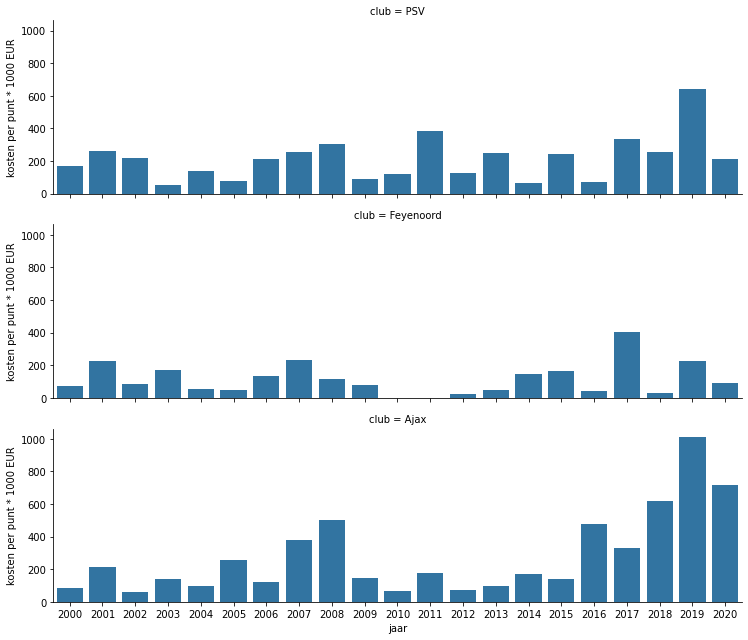

In [15]:
g = sns.FacetGrid(topclub_standen, row='club', height=3, aspect=3.5)
g.map(sns.barplot, 'jaar', 'kosten per punt * 1000 EUR')


## Gevolgen op de eindrangschikking

Nu we weten wat de clubs uitgeven per punt gaan we kijken wat voor gevolgen dit heeft voor de eindrangschikking. De kampioensschaal wordt uiteindelijk uitgedeeld aan het team met de meeste punten. Niet aan diegene die de duurste punten heeft.


In [16]:
from matplotlib import pyplot as plt


In onderstaande scatterplot gaan we zien wat de relatie is tussen de uitgaven per punt en de eindrangschikking.


<AxesSubplot:xlabel='kosten per punt * 1000 EUR', ylabel='rangschikking'>

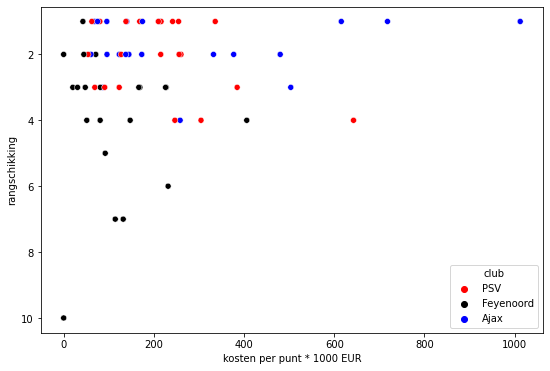

In [17]:
# de grootte van onderstaande tabel aanpassen
fig, ax = plt.subplots(figsize=(9, 6))
# zorg dat eindplaats rangschikking 1 bovenaan staat
ax.invert_yaxis()
sns.scatterplot(data=topclub_standen, x='kosten per punt * 1000 EUR', y='rangschikking', hue='club', palette=['red', 'black', 'blue'])



Ondanks dat er niet heel veel data zijn is er wel een en ander op te maken uit deze scatterplot.

Als de uitgave hoog is per punt, dan resulteert dat ook vaak in een hoge eindrangschikking. Een lagere uitgave per punt sluit niet uit dat een hoge eindrangschikking behaalt wordt.



### Is er per club een trend te zien in hoe 'goed' zij hun geld besteden?

Uit voorgaande plot kunnen we dus opmaken dat een hoge uitgave vaak leidt tot een topklassering, maar dat met een lage uitgave per punt er ook goede klasseringen behaalt kunnen worden.

Interessant om te kijken hoe de clubs het individueel doen.



#### Ajax

Als je naar de plot van Ajax kijkt dan zie je dat ze in 20 jaar slechts 3 keer buiten de top 2 zijn geeindigd. Iets meer dan de helft van deze periode hebben zij minder dan 200K per punt uitgegeven. Van deze keren zijn ze slechts 1 keer buiten de top 2 geeindigd.
Je kunt hieruit concluderen dat zij hun geld goed besteden.


<AxesSubplot:xlabel='kosten per punt * 1000 EUR', ylabel='rangschikking'>

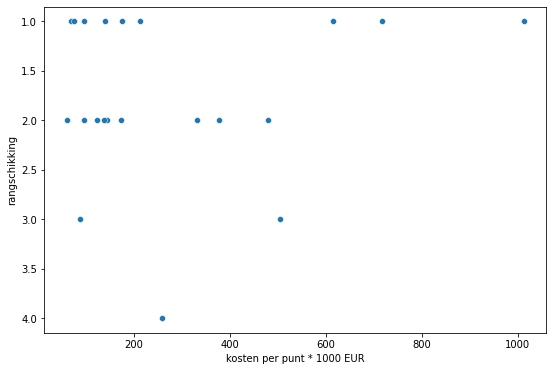

In [18]:
ajax = topclub_standen[topclub_standen['club'] == 'Ajax']
# de grootte van onderstaande tabel aanpassen
fig, ax = plt.subplots(figsize=(9, 6))
# zorg dat eindplaats rangschikking 1 bovenaan staat
ax.invert_yaxis()
sns.scatterplot(data=ajax, x='kosten per punt * 1000 EUR', y='rangschikking')


#### Feyenoord

Feyenoord heeft de laatste 20 jaar 17 x minder dan 200K per punt besteed. Daarmee zijn ze slecht 4 x in de top 2 gekomen en zelfs 7 keer buiten de top 3 zijn geeindigd. Verder valt up dat de hoogste uitgave per punt resulteerde in slechts een 4e plaats.
Verrassend is verder dat zij in een van de 2 jaren dat ze 0.00 hebben uitgegeven, zij toch nog als 2 zijn geeindigd.
Over het algemeen kun je concluderen dat de euros bij Feyenoord niet juist besteed worden.


<AxesSubplot:xlabel='kosten per punt * 1000 EUR', ylabel='rangschikking'>

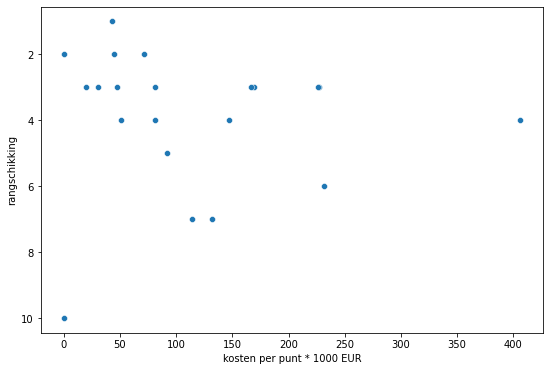

In [19]:
feyenoord = topclub_standen[topclub_standen['club'] == 'Feyenoord']
# de grootte van onderstaande tabel aanpassen
fig, ax = plt.subplots(figsize=(9, 6))
# zorg dat eindplaats rangschikking 1 bovenaan staat
ax.invert_yaxis()
sns.scatterplot(data=feyenoord, x='kosten per punt * 1000 EUR', y='rangschikking')


#### PSV

Als je naar PSV kijk zie je dat ze de helft van de keren minder dan 200K per punt hebben besteed en daarvan 6 keer in de top 2 zijn gekomen (4x kampioen). Daarnaast zitten zij er voor de rest niet vaak boven de 200K, maar tot de 300K per punt worden ze nog eens 4 x kampien en 3 x 2e. 
Frappant is ook hier dat de hoogste uitgave per punt resulteerde in een teleurstellende 4e plaats.
PSV lijkt wel het maximale uit hun geld te halen.


<AxesSubplot:xlabel='kosten per punt * 1000 EUR', ylabel='rangschikking'>

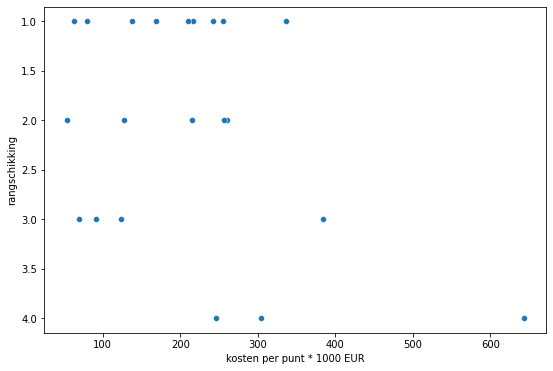

In [20]:
psv = topclub_standen[topclub_standen['club'] == 'PSV']
# de grootte van onderstaande tabel aanpassen
fig, ax = plt.subplots(figsize=(9, 6))
# zorg dat eindplaats rangschikking 1 bovenaan staat
ax.invert_yaxis()
sns.scatterplot(data=psv, x='kosten per punt * 1000 EUR', y='rangschikking')